Import libraries and packages

In [1]:
import pandas as pd
import datetime
import regex as re
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

import warnings
warnings.filterwarnings('ignore')

Import Dataset

In [2]:
eth = pd.read_csv('/kaggle/input/ethereum-historical-data/ethereum_price.csv')

In [3]:
eth.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 08, 2023","1,553.49","1,561.79","1,569.70","1,548.98",498.57K,-0.53%
1,"Mar 07, 2023","1,561.78","1,565.84","1,580.95","1,536.31",460.10K,-0.26%
2,"Mar 06, 2023","1,565.84","1,564.36","1,581.13","1,555.43",322.16K,0.09%
3,"Mar 05, 2023","1,564.37","1,566.73","1,587.95","1,556.84",313.01K,-0.15%
4,"Mar 04, 2023","1,566.73","1,569.45","1,577.02","1,550.10",247.02K,-0.14%


Data Preprocessing

In [4]:
eth['Date'] = pd.to_datetime(eth.Date)

for i in range(len(eth)):
    eth['Price'][i] = float(re.sub(',', '', eth['Price'][i]))
    eth['Open'][i] = float(re.sub(',', '', eth['Open'][i]))
    eth['High'][i] = float(re.sub(',', '', eth['High'][i]))
    eth['Low'][i] = float(re.sub(',', '', eth['Low'][i]))
    eth['Change %'][i] = float(re.sub('%', '', eth['Change %'][i]))
    if eth['Vol.'][i][-1] == 'K':
        eth['Vol.'][i] = int(float(re.sub('K', '', eth['Vol.'][i])) * 1000) 
    elif eth['Vol.'][i][-1] == 'M':
        eth['Vol.'][i] = int(float(re.sub('M', '', eth['Vol.'][i])) * 1000000) 

eth.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-03-08,1553.49,1561.79,1569.7,1548.98,498570,-0.53
1,2023-03-07,1561.78,1565.84,1580.95,1536.31,460100,-0.26
2,2023-03-06,1565.84,1564.36,1581.13,1555.43,322160,0.09
3,2023-03-05,1564.37,1566.73,1587.95,1556.84,313010,-0.15
4,2023-03-04,1566.73,1569.45,1577.02,1550.1,247020,-0.14


In [5]:
eth.shape

(2555, 7)

In [6]:
print('Total number of days :', eth.Date.nunique())
print('Total number of fields :', eth.shape[1])

Total number of days : 2555
Total number of fields : 7


Chceking Null and NA values

In [7]:
print("Null values :", eth.isnull().values.sum())
print("NA values :", eth.isna().values.any())

Null values : 0
NA values : False


Finding out the duration of dataset

In [8]:
print("Starting date :", eth.iloc[-1][0])
print("Ending date :", eth.iloc[0][0])
print("Duration :", eth.iloc[0][0]- eth.iloc[-1][0])

Starting date : 2016-03-10 00:00:00
Ending date : 2023-03-08 00:00:00
Duration : 2554 days 00:00:00


Monthwise comparisions

In [9]:
monthwise = eth.groupby(pd.DatetimeIndex(eth.Date).month)[['Open']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthwise = monthwise.reset_index()
monthwise['Date'] = new_order

monthwise

,Date,Open
0,January,1012.926636
1,February,1057.254670
2,March,856.974306
3,April,897.661762
4,May,940.999447
5,June,729.158619
6,July,666.152673
7,August,857.359770
8,September,848.079286
9,October,888.357926


In [10]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x = monthwise.Date,
    y = monthwise['Open'],
    name = 'Stock Open Price',
    marker_color = 'pink'
))
fig.update_layout(barmode = 'group', xaxis_tickangle = -45, 
                  title = 'Monthwise comparision for Open Prices')
fig.show()

Monthwise comparision for High and Low prices

In [11]:
monthwise_high = eth.groupby(pd.DatetimeIndex(eth.Date).month)['High'].max()
monthwise_high = monthwise_high.reset_index()
monthwise_high['Date'] = new_order

monthwise_low = eth.groupby(pd.DatetimeIndex(eth.Date).month)['Low'].min()
monthwise_low = monthwise_low.reset_index()
monthwise_low['Date'] = new_order

In [12]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x = monthwise_high.Date,
    y = monthwise_high.High,
    name = 'Stock High Price',
    marker_color = 'purple'
))
fig.add_trace(go.Bar(
    x = monthwise_low.Date,
    y = monthwise_low.Low,
    name = 'Stock Low Price',
    marker_color='pink'
))

fig.update_layout(barmode='group', xaxis_tickangle = -45,
                  title=' Monthwise High and Low Price')
fig.show()

Trend comparision between open, high and low prices

In [13]:
names = cycle(['Eth Open Price','Eth High Price','Eth Low Price'])

fig = px.line(eth, x = eth.Date, y = [eth['Open'], eth['High'], eth['Low']],
             labels = {'date': 'Date','value':'Eth value'})
fig.update_layout(title_text = 'Ethereum Price analysis chart', font_size = 15, font_color = 'black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)

fig.show()

Preparing Ethereum open price

In [14]:
open_eth = eth[['Date', 'Open']]
print(open_eth.shape)
open_eth.head()

(2555, 2)


,Date,Open
0,2023-03-08,1561.79
1,2023-03-07,1565.84
2,2023-03-06,1564.36
3,2023-03-05,1566.73
4,2023-03-04,1569.45


In [15]:
fig = px.line(open_eth, x = open_eth.Date, y = open_eth.Open,labels = {'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width = 2, opacity = 0.8)
fig.update_layout(title_text = 'Stock close price chart', plot_bgcolor = 'white', font_size = 15, font_color = 'black')
fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.show()

Considering only last 1 year data for prediction purposes.

In [16]:
open_eth = open_eth[open_eth['Date'] > '2022-03-08']
open_stock = open_eth.copy()
print("Total data for prediction: ",open_stock.shape[0])

Total data for prediction:  365


In [17]:
fig = px.line(open_stock, x = open_stock.Date, y = open_stock.Open, labels = {'Date':'Date','Open':'Open Stock Price'})
fig.update_traces(marker_line_width = 2, opacity = 0.8, marker_line_color = 'orange')
fig.update_layout(title_text = 'Considered period to predict Ethereum close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.show()

Normalizing Open Price

In [18]:
del open_stock['Date']
scaler = MinMaxScaler(feature_range = (0,1))
open_stock = scaler.fit_transform(np.array(open_stock).reshape(-1,1))
print(open_stock.shape)

(365, 1)


Preparing data for train and test

In [19]:
train_size = int(len(open_stock)*0.75)
test_size = len(open_stock) - train_size
train_data , test_data = open_stock[0:train_size, :] ,open_stock[train_size:len(open_stock),:1]
print("Train_data :", train_data.shape)
print("Test_data :", test_data.shape)

Train_data : (273, 1)
Test_data : (92, 1)


Converting Open price based on Time Series Forecasting requirement

In [20]:
#Converting the array of values into a dataset matrix
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]    
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [21]:
time_step = 15
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", x_test.shape)
print("y_test", y_test.shape)

X_train:  (257, 15)
y_train:  (257,)
X_test:  (76, 15)
y_test (76,)


Model Building (GRU)

GRUs (Gated Recurrent Units) are very similar to Long Short Term Memory(LSTM). Just like LSTM, GRU uses gates to control the flow of information. They are relatively new as compared to LSTM. This is the reason they offer some improvement over LSTM and have simpler architecture.

In [22]:
#Reshaping input to be of format [samples, time steps, features] which is reuqired for LSTM
x_train_lstm = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_lstm = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

print(x_train_lstm.shape, x_test_lstm.shape)

(257, 15, 1) (76, 15, 1)


In [23]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(GRU(32, return_sequences = True, input_shape = (time_step, 1)))
model.add(GRU(32, return_sequences = True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(x_train_lstm, y_train, validation_data = (x_test_lstm, y_test), epochs = 200, batch_size = 32, verbose = 1)

Epoch 1/200
9/9 [==============================] - 8s 175ms/step - loss: 0.0120 - val_loss: 0.0621
Epoch 2/200
9/9 [==============================] - 0s 27ms/step - loss: 0.0052 - val_loss: 0.1355
Epoch 3/200
9/9 [==============================] - 0s 27ms/step - loss: 0.0037 - val_loss: 0.0465
Epoch 4/200
9/9 [==============================] - 0s 26ms/step - loss: 0.0031 - val_loss: 0.0415
Epoch 5/200
9/9 [==============================] - 0s 27ms/step - loss: 0.0028 - val_loss: 0.0307
Epoch 6/200
9/9 [==============================] - 0s 27ms/step - loss: 0.0025 - val_loss: 0.0163
Epoch 7/200
9/9 [==============================] - 0s 28ms/step - loss: 0.0025 - val_loss: 0.0131
Epoch 8/200
9/9 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0091
Epoch 9/200
9/9 [==============================] - 0s 27ms/step - loss: 0.0023 - val_loss: 0.0109
Epoch 10/200
9/9 [==============================] - 0s 28ms/step - loss: 0.0022 - val_loss: 0.0068
Epoch 11/200
9/9 [

Plotting loss charts

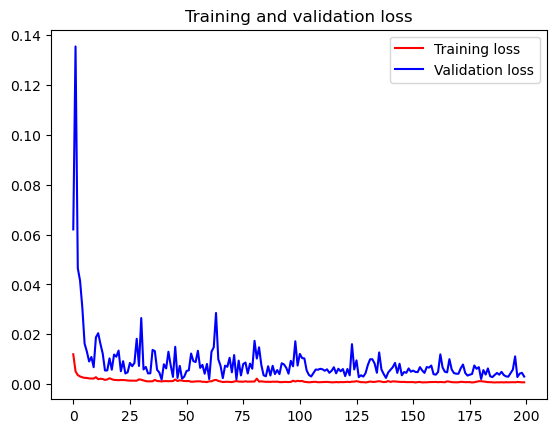

<Figure size 640x480 with 0 Axes>

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [27]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
print(train_predict.shape, test_predict.shape)

3/3 [==============================] - 0s 7ms/step
(257, 1) (76, 1)


Model Evaluation

In [28]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

Evaluation metrics : RMSE, MSE, MAE

In [29]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  63.34053376920244
Train data MSE:  4012.0232181674746
Train data MAE:  42.95009051252432
-------------------------------------------------------------------------------------
Test data RMSE:  139.70175170694264
Test data MSE:  19516.57942998825
Test data MAE:  109.01316733912417


Explained Variance Regression Score:

The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [30]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9132521821190525
Test data explained variance regression score: 0.9356093659055179


R2 score for regression:

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.


In [31]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9129446526298766
Test data R2 score: 0.899547328069868


Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [32]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.002051539750017713
Test data MGD:  0.0027277277746884667
----------------------------------------------------------------------
Train data MPD:  2.8395009023371176
Test data MPD:  7.20263749070125


Comparison of original ethereum open price and predicted ethereum open price

In [33]:
look_back = time_step
train_predict_plot = np.empty_like(open_stock)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back : len(train_predict) + look_back, :] = train_predict
print("Train predicted data: ", train_predict_plot.shape)

# shift test predictions for plotting
test_predict_plot = np.empty_like(open_stock)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(open_stock) - 1, :] = test_predict
print("Test predicted data: ", test_predict_plot.shape)

names = cycle(['Original Open price','Train predicted Open price','Test predicted Open price'])

plotdf = pd.DataFrame({'Date': open_eth['Date'],
                       'original_open': open_eth['Open'],
                      'train_predicted_open': train_predict_plot.reshape(1,-1)[0].tolist(),
                      'test_predicted_open': test_predict_plot.reshape(1,-1)[0].tolist()})
plotdf['original_open'] = plotdf['original_open'].astype(np.float64)

fig = px.line(plotdf, x = plotdf['Date'], y = [plotdf['original_open'], plotdf['train_predicted_open'], plotdf['test_predicted_open']],
              labels = {'value':'Ethereum price','Date': 'Date'})
fig.update_layout(title_text = 'Comparision between original Open price vs predicted Open price',
                  plot_bgcolor = 'white', font_size = 15, font_color = 'black', legend_title_text = 'Open Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (365, 1)
Test predicted data:  (365, 1)


Predicting for the next 30 days

In [34]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


Plotting last 15 days of dataset and next predicted 30 days

In [35]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [36]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(open_stock[len(open_stock)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days Open price','Predicted next 30 days Open price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Ethereum price','index': 'Timestamp'})
fig.update_layout(title_text='Comparing last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Plotting entire Opening Stock Price with next 30 days period of prediction

In [37]:
lstmdf=open_stock.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()